# Decision Trees

In this tutorial, we will be looking at implementing the Decision Tree tools that are avaiable from scikit-learn. In particular we will be looking applying a simple decision tree, using the Gini Index, to the Iris dataset, followed by a more complex dataset. Both are classification problems. 

In [1]:
# preamble
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

import graphviz 
import pydotplus

# Helper function to plot the decision tree. This uses the graphviz library.
def plot_tree(graph, feature_names=None, class_names=None):
    '''
    This method takes a DecisionTreeClassifier object, along with a list of feature names and target names
    and plots a tree. The feature names and class names can be left empty; they are just there for labelling 
    '''

    dot_data = export_graphviz(graph, out_file=None, 
                      feature_names=feature_names,  
                      class_names=class_names,  
                      filled=True, rounded=True,  
                      special_characters=True) 
    
    graph = graphviz.Source(dot_data)
    
    return graph


## Iris Dataset

In [2]:
# Load the iris dataset using the helper function provided by scikit-learn
from sklearn.datasets import load_iris

iris = load_iris()

iris_X = iris.data
iris_y = iris.target

As an example, we can create a DecisionTreeClassifier object from scikit-learn. This has several options that we can change, but for now, let's see what the default tree looks like for the full iris dataset.

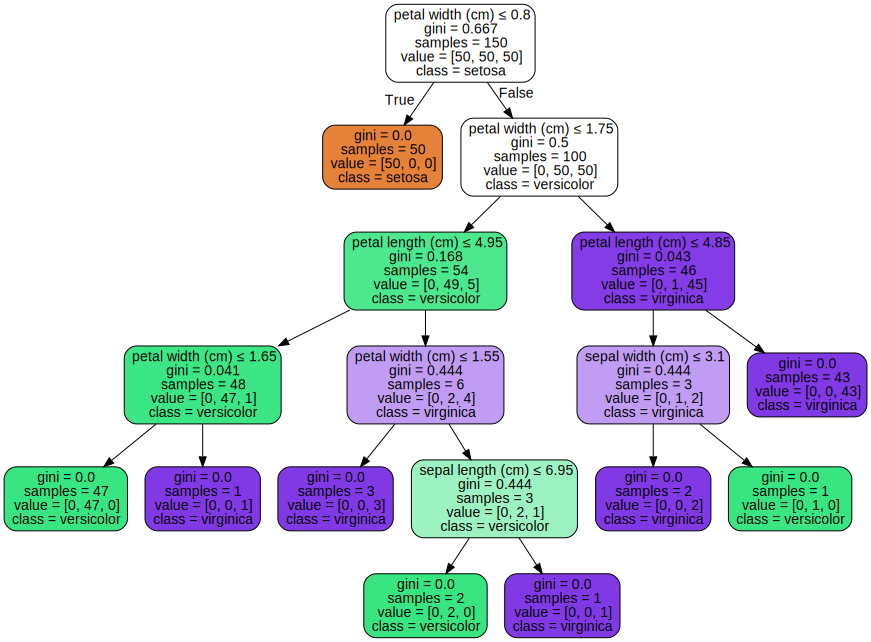

In [3]:
# We initialise the DecisionTreeClassifier object. We can set our hyperparameters here if necessary; we'll look into this in a bit.
base_model = DecisionTreeClassifier()

# DecisionTreeClassifier has a fit method, which takes the train X and train y to learn a tree. The necessary optimisation is done here. 
fitted_base_model = base_model.fit(iris_X, iris_y)

# Use the helper function defined above to plot the learned model.
plot_tree(fitted_base_model, iris.feature_names, iris.target_names)

Note that as per the [documentation](https://scikit-learn.org/stable/modules/tree.html), DecisionTreeClassfier implements a modified version of CART. You can look at documentation for details about the particular algorithm scikit-learn implements. 

Since it implements CART, by default, DecisionTreeClassifier uses the Gini Index to measure the leaf impurity. You can also use the entropy information gain by setting `criterion='entropy'` when initialising the object. 

Other options available can be seen [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier). A key option is the `max_depth`. This defines the maximum depth of the tree. If this isn't set, as above, the algorithm will continue until all leaves are pure, or until all leaves contain less than `min_samples_split` samples; this is another setting we can set. 

In other words, this setting prunes the full tree seen above until the longest path in the tree is equal to `max_depth`. Pruning simplifies the model by removing roots that lead to relatively low information gains. This in turn makes the model more interpretable to humans, and also prevents overfitting. 

Lets look at how the `max_depth` affects the accuracy of the model. 

Accuracy: 0.9555555555555556


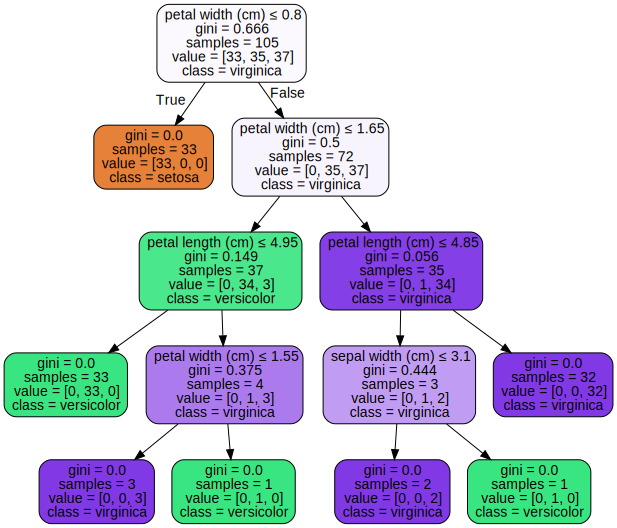

In [4]:
# Create a test-train data split. 
from sklearn.model_selection import train_test_split

# We have set the random seed to be 2, by setting the random_state parameter. 
X_train, X_test, y_train, y_test = train_test_split(iris_X, iris_y, test_size=0.3, random_state=2)

# Initialise a new model that uses the default `max_depth`. The code pattern is the same as above.
# i.e 1) Create a DecisionTreeclassifier object with the correct hyperparameters. This is your model.
# 2) use the DecisionTreeclassifier.fit(X, y) function to optimise the model.
# 3) use the DecisionTreeclassifier.predict(X) to make predictions
# 4) use metrics.accuracy_score(y_test, y_predictions) to compute accuracy scores.

# 1)
full_model = DecisionTreeClassifier()

# 2)
fitted_full_model = full_model.fit(X_train, y_train)

#3) 
predictions = fitted_full_model.predict(X_test)

#4) 
full_model_accuracy = metrics.accuracy_score(y_test, predictions)

print(f'Accuracy: {full_model_accuracy}')
plot_tree(fitted_full_model, iris.feature_names, iris.target_names)

Accuracy: 0.9777777777777777


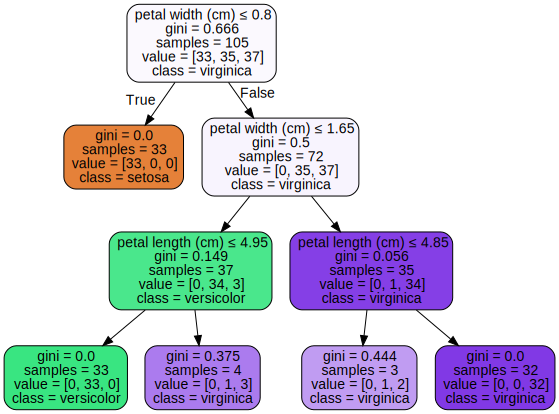

In [5]:
# Initialise another model that sets `max_depth=3`. The code pattern is the same as above.

# 1)
small_model = DecisionTreeClassifier(max_depth=3)
# 2)
fitted_small_model = small_model.fit(X_train, y_train)
# 3)
predictions = fitted_small_model.predict(X_test)
# 4)
small_model_accuracy = metrics.accuracy_score(y_test, predictions)

print(f'Accuracy: {small_model_accuracy}')
plot_tree(fitted_small_model, iris.feature_names, iris.target_names)

We can see here that our accuracy has improved, albeit slightly.
Note however, that this is dependent on the random seed that we used (since we only ran this once).
You can try changing the random_state parameter above when we used the train_test_split function, and see if the result above changes.

We can now do a more extensive search by doing a grid search to search over several `max_depth` values.

In [6]:
# Try using the GridSearchCV from sklearn.model_selection. 
# You can specifiy the set of `max_depth`s that you want to try by setting `param_grid={'max_depth':[1, 2, 3, 4, 5, 6]}`.
# Documentation can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

from sklearn.model_selection import GridSearchCV

# The code pattern here is similar to the previous sections. 
# 1) Initiate a GridSearchCV object with the correct model, param_grid, and cv; `cv=k` does a k-fold cross-validation.
grid_search_model = GridSearchCV(DecisionTreeClassifier(random_state=2), {'max_depth':[1, 2, 3, 4, 5, 6]}, cv=15,)

# 2) use the GridSearchCV.fit(X, y) method to run the grid search with cv. 
fitted_grid_search_model = grid_search_model.fit(iris_X, iris_y)

Mean accurary scores:[0.63333333 0.95333333 0.95333333 0.96       0.96       0.96      ]


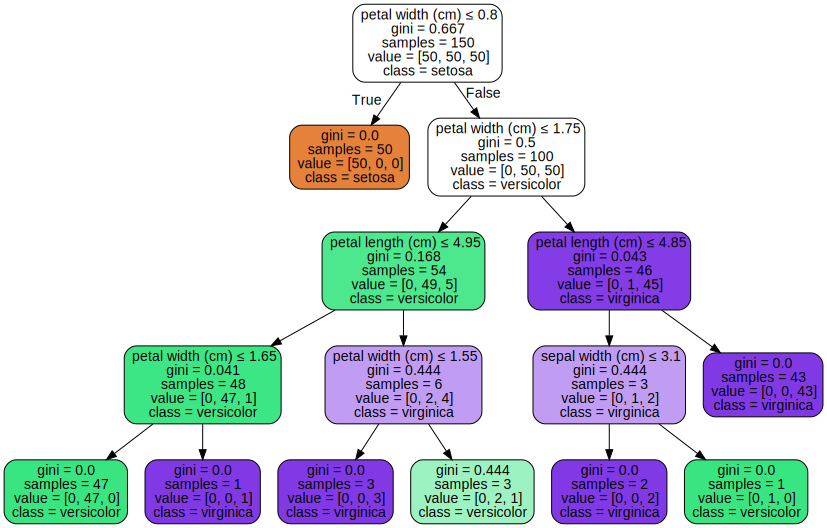

In [13]:
# Print the mean accuracy scores. 
# The fitted GridSearchCV object has an attribute model.cv_results_ (note the underscore) that gives us a dict object with several results from the cross-valiation. 
# In particular, one of the key value pairs avaiable is 'mean_test_score', which returns the average score for each parameter value over the cv fold. 

accuracy_scores = fitted_grid_search_model.cv_results_['mean_test_score']
print(f"Mean accurary scores:{accuracy_scores}")

# Plot the best estimator you found
# GridSearchCV.best_estimator_ (again, the underscore) returns the model that performed the best. This behaves the same as the models from before, so we can plot it.
best_tree_model = fitted_grid_search_model.best_estimator_

plot_tree(best_tree_model, iris.feature_names, iris.target_names)

# PIMA-INDIAN Dataset
Now lets do the same analysis for a much more complicated dataset. Details about this dataset can be found [here](https://www.kaggle.com/uciml/pima-indians-diabetes-database). As a summary, it contains 768 data points with 8 features and a single binary target variable.

In [8]:
import pandas as pd

col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']

# load dataset. Here we are loading into Pandas, since the data is available as a csv file.
# The DecisionTreeClassifier object can accept dataframes when fitting. 
pima = pd.read_csv("diabetes.csv", names=col_names)

print(pima.head())

pima_feature_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age']
pima_class_names = ['True', 'False']

pima_X = pima[pima_feature_names]
pima_y = pima.label

   pregnant  glucose  bp  skin  insulin   bmi  pedigree  age  label
0         6      148  72    35        0  33.6     0.627   50      1
1         1       85  66    29        0  26.6     0.351   31      0
2         8      183  64     0        0  23.3     0.672   32      1
3         1       89  66    23       94  28.1     0.167   21      0
4         0      137  40    35      168  43.1     2.288   33      1


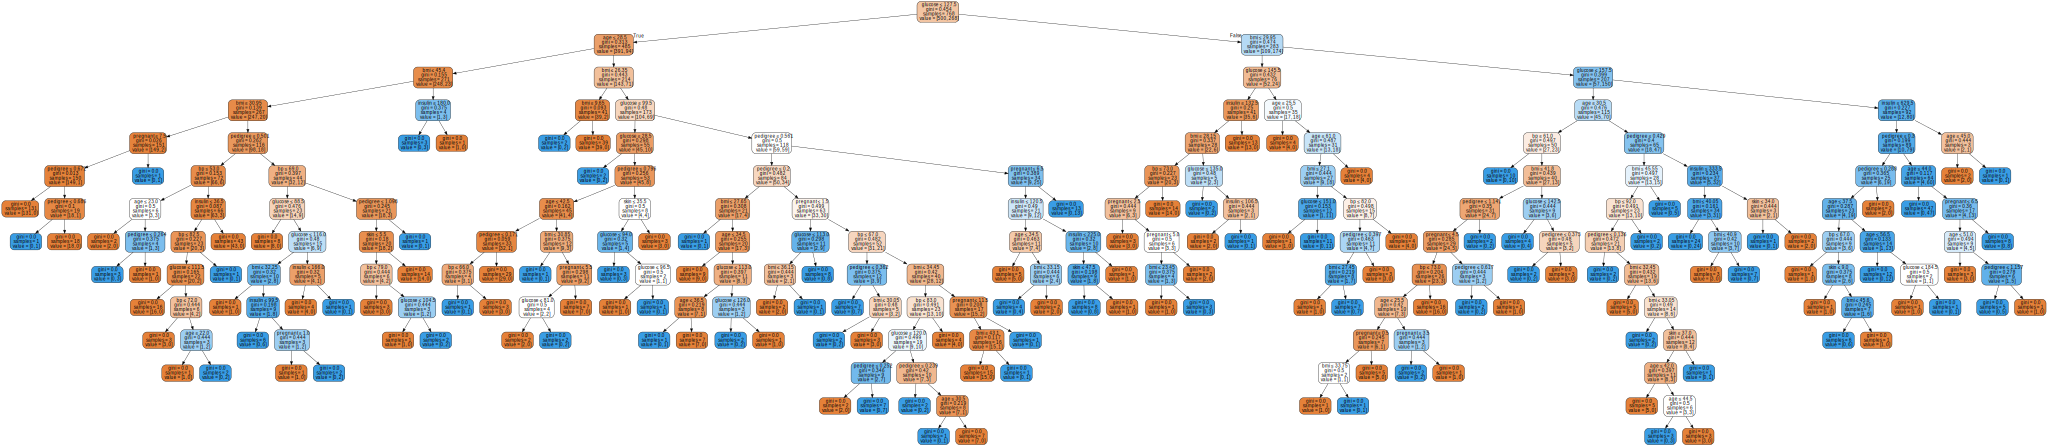

In [9]:
# As before, lets look at what the tree looks like with default settings.
# Follow the example in Cell 3 above, where we did something similar on the Iris Dataset.
pima_full_model = DecisionTreeClassifier()
fitted_pima_full_model = pima_full_model.fit(pima_X, pima_y)

plot_tree(fitted_pima_full_model, pima_feature_names)

We can see here that this is quite unwieldy. 

Lets immediately jump into see do the grid search, and see if we can do better with a smaller tree. 

Note from the previous cell that the depth of this graph is 14, so the highest depth we need to look at is 14.

In [10]:
pima_grid_search_model = GridSearchCV(DecisionTreeClassifier(random_state=1), {'max_depth':range(1, 15)}, cv=15,)
fitted_pima_grid_search_model = pima_grid_search_model.fit(pima_X, pima_y)

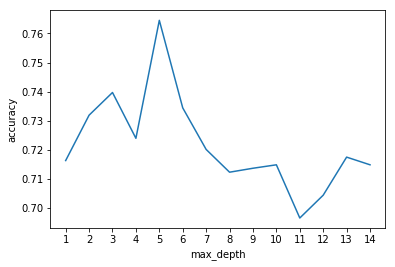

In [11]:
# plot the mean accuracy scores. 
# As before we can use GridSearchCV.cv_results_['mean_test_score'] for this.

from matplotlib import pyplot as plt
%matplotlib inline

x = range(1, fitted_pima_grid_search_model.cv_results_['mean_test_score'].shape[0]+1)
plt.plot(x, fitted_pima_grid_search_model.cv_results_['mean_test_score'])
plt.xlabel('max_depth')
plt.ylabel('accuracy')
_ = plt.xticks(x)


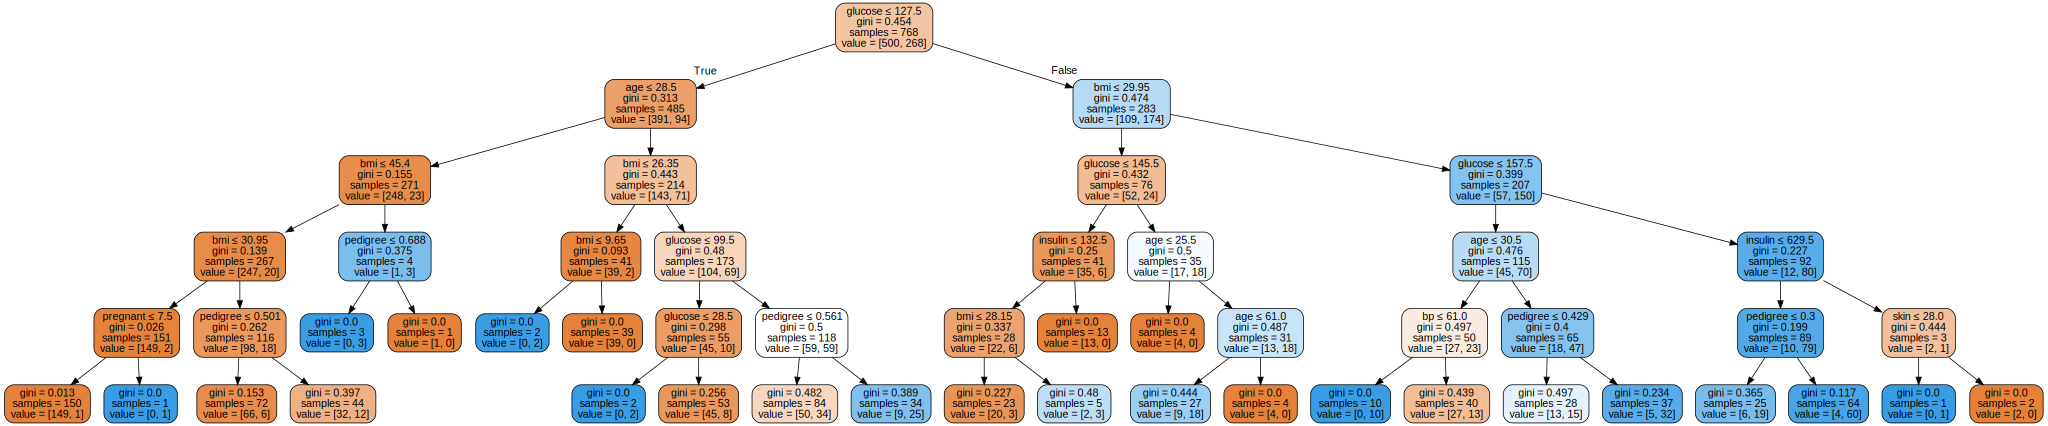

In [12]:
# Plot the best estimator you found
pima_best_tree_model = fitted_pima_grid_search_model.best_estimator_
plot_tree(pima_best_tree_model, pima_feature_names)

# As we can see, this is much more interpretable, and also has a better accuracy score.